# Hedging Strategy Comparison

This notebook implements the systematic comparison between:
1.  **Factor-Based Hedging**: Using the mathematical optimization framework (minimize factor risk subject to constraints).
2.  **NLP-Based Hedging**: Using semantic similarity (Cosine Similarity on Embeddings) to find "fundamental" peers.

We loop through a sample of our universe, construct both hedges, and backtest their effectiveness by calculating the **Realized Hedged Volatility** over the test period.

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.metrics.pairwise import cosine_similarity

# Import custom modules
from adv_hedging.data.loaders import load_wiki_data, load_risk_factors
from adv_hedging.hedging.optimization import optimize_hedge_weights
from adv_hedging.hedging.metrics import calculate_hedged_volatility
from adv_hedging.config import PROCESSED_DATA_DIR

plt.style.use('ggplot')

# Load the processed data from previous steps
# (If these fail, make sure you ran Notebook 01 and 02!)
try:
    df_factor_rets = pd.read_parquet(PROCESSED_DATA_DIR / "factor_returns_robust.parquet")
    df_cov = pd.read_parquet(PROCESSED_DATA_DIR / "factor_covariance.parquet")
    print("✅ Loaded Factor Model Data")
except FileNotFoundError:
    print("❌ Factor data missing. Please run Notebook 01 first.")

try:
    # Check for Nomic first (best), then fallback to MPNet
    nomic_path = PROCESSED_DATA_DIR / "nomic_embeddings.parquet"
    if nomic_path.exists():
        df_nomic = pd.read_parquet(nomic_path)
        df_wiki = load_wiki_data()
        df_wiki = df_wiki.merge(df_nomic, on='ticker', how='left')
        EMBEDDING_COL = 'embedding_nomic'
        print("✅ Loaded Nomic Embeddings")
    else:
        df_wiki = load_wiki_data()
        EMBEDDING_COL = 'embedding_mpnet'
        print("⚠️ Nomic embeddings not found. Falling back to MPNet (run Notebook 02 for better results).")
except Exception as e:
    print(f"❌ Error loading embeddings: {e}")

✅ Loaded Factor Model Data
✅ Loaded Nomic Embeddings


## 1. Prepare Universe
We need to align three datasets:
1.  **Returns**: Real historical prices (from Notebook 01's yfinance download).
2.  **Factors**: The Bloomberg exposure data.
3.  **Embeddings**: The Wikipedia NLP data.

We only run the test on companies that exist in ALL three datasets.

In [11]:
import yfinance as yf
from adv_hedging.data.loaders import load_wiki_data, load_risk_factors

# 1. Load Factors (Fresh Load)
df_factors_raw = load_risk_factors()
rename_map = {
    'Ticker.1': 'ticker',
    'PORT US Sz Fact Exp:D-1': 'Size',
    'PORT US Val Fact Exp:D-1': 'Value',
    'PORT US Mom Fact Exp:D-1': 'Momentum',
    'PORT US Vol Fact Exp:D-1': 'Volatility',
    'PORT US Prof Fact Exp:D-1': 'Profitability',
    'PORT US Lev Fact Exp:D-1': 'Leverage',
    'PORT US Trd Act Fact Exp:D-1': 'Trading_Activity'
}
factor_cols = list(rename_map.values())[1:] # Skip 'ticker', keep 7 factors

# Rename and Clean Tickers
exposures = df_factors_raw.rename(columns=rename_map).set_index('ticker')[factor_cols].dropna()
exposures.index = [t.split()[0] for t in exposures.index]

# 2. Load Wiki Data (Fresh Load to fix KeyError)
# We reload it here to ensure 'ticker' is definitely a column
df_wiki = load_wiki_data()

# Re-merge Nomic embeddings if they exist (from Cell 2 logic)
nomic_path = PROCESSED_DATA_DIR / "nomic_embeddings.parquet"
if nomic_path.exists():
    df_nomic = pd.read_parquet(nomic_path)
    # Only merge if not already merged
    if 'embedding_nomic' not in df_wiki.columns:
        df_wiki = df_wiki.merge(df_nomic, on='ticker', how='left')
    EMBEDDING_COL = 'embedding_nomic'
else:
    EMBEDDING_COL = 'embedding_mpnet'

print("Verifying return data...")

# 3. Calculate Intersection
# Now this works because we freshly loaded df_wiki with 'ticker' as a column
common_tickers = list(set(exposures.index) & set(df_wiki['ticker']))
print(f"Intersection Universe: {len(common_tickers)} stocks")

if len(common_tickers) == 0:
    raise ValueError("Error: No common tickers found! Check ticker formats.")

# 4. Download Returns
# We grab 1 year of data
returns_df = yf.download(
    common_tickers, 
    start="2024-01-01", 
    end="2025-01-01", 
    auto_adjust=True, 
    progress=False
)['Close'].pct_change().dropna(how='all')

# 5. Final Alignment
# Ensure all 3 datasets have exactly the same stocks in the same order
common_tickers = [t for t in common_tickers if t in returns_df.columns]
returns_df = returns_df[common_tickers].fillna(0.0)
exposures = exposures.loc[common_tickers]

# Filter Wiki and Set Index
df_wiki = df_wiki[df_wiki['ticker'].isin(common_tickers)].set_index('ticker')
df_wiki = df_wiki.loc[common_tickers] # Enforce order

# Prepare Embedding Matrix
valid_emb_mask = df_wiki[EMBEDDING_COL].notna()
df_wiki = df_wiki[valid_emb_mask]
embedding_matrix = np.stack(df_wiki[EMBEDDING_COL].values)
ticker_map = {tick: i for i, tick in enumerate(df_wiki.index)}

print(f"Final Test Universe: {len(df_wiki)} stocks aligned.")

Verifying return data...
Intersection Universe: 650 stocks


$JBS: possibly delisted; no price data found  (1d 2024-01-01 -> 2025-01-01) (Yahoo error = "Data doesn't exist for startDate = 1704085200, endDate = 1735707600")
$VG: possibly delisted; no price data found  (1d 2024-01-01 -> 2025-01-01) (Yahoo error = "Data doesn't exist for startDate = 1704085200, endDate = 1735707600")
$SFD: possibly delisted; no price data found  (1d 2024-01-01 -> 2025-01-01) (Yahoo error = "Data doesn't exist for startDate = 1704085200, endDate = 1735707600")
$GLXY: possibly delisted; no price data found  (1d 2024-01-01 -> 2025-01-01) (Yahoo error = "Data doesn't exist for startDate = 1704085200, endDate = 1735707600")
$BLSH: possibly delisted; no price data found  (1d 2024-01-01 -> 2025-01-01) (Yahoo error = "Data doesn't exist for startDate = 1704085200, endDate = 1735707600")
$CRWV: possibly delisted; no price data found  (1d 2024-01-01 -> 2025-01-01) (Yahoo error = "Data doesn't exist for startDate = 1704085200, endDate = 1735707600")
$COOP: possibly delisted; 

Final Test Universe: 650 stocks aligned.


/var/folders/x9/qm1wqkb56hgfqvnwptpd40k40000gn/T/ipykernel_7327/4265754490.py:55: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  )['Close'].pct_change().dropna(how='all')


## 2. Systematic Evaluation Loop
We will iterate through a random sample of 50 stocks (to save time) and for each stock:
1.  Construct a **Factor Hedge** (using Optimization).
2.  Construct an **NLP Hedge** (using Cosine Similarity neighbors).
3.  Calculate the **Hedged Volatility** of both strategies over the last year.

* **Hypothesis**: The NLP hedge should outperform on idiosyncratic stocks (e.g., Biotech) where "Factors" don't capture the specific risks.

In [12]:
results = []
sample_size = 50
np.random.seed(42)

# Pick random targets
test_targets = np.random.choice(df_wiki.index, size=sample_size, replace=False)

# Dummy Specific Risk (In a full Barra model, we'd estimate this. Here we assume constant for stability)
spec_risk = pd.Series(0.15, index=exposures.index)

print(f"Starting Backtest on {sample_size} stocks...")

for target in tqdm(test_targets):
    # --- 1. Factor Hedge ---
    try:
        # Define Hedge Universe (everyone except the target)
        hedge_universe = exposures.drop(target)
        target_exp = exposures.loc[target]
        
        # Optimize
        w_factor = optimize_hedge_weights(
            target_exp, 
            hedge_universe, 
            df_cov, 
            spec_risk.drop(target),
            max_positions=10 # Constraint from assignment
        )
        
        # Calculate Realized Volatility
        hedge_ret_series = returns_df[hedge_universe.index]
        vol_factor = calculate_hedged_volatility(returns_df[target], hedge_ret_series, w_factor)
        
    except Exception as e:
        # Optimization might fail if data is weird
        vol_factor = np.nan

    # --- 2. NLP Hedge ---
    try:
        idx = ticker_map[target]
        target_emb = embedding_matrix[idx].reshape(1, -1)
        
        # Cosine Sim
        sims = cosine_similarity(target_emb, embedding_matrix)[0]
        sims[idx] = -1 # Exclude self
        
        # Pick Top 10 Neighbors
        top_10_idx = np.argsort(sims)[-10:]
        nlp_tickers = df_wiki.index[top_10_idx]
        
        # Equal Weights (Simple approach)
        w_nlp = pd.Series(0.1, index=nlp_tickers)
        
        # Calculate Realized Volatility
        nlp_ret_series = returns_df[nlp_tickers]
        vol_nlp = calculate_hedged_volatility(returns_df[target], nlp_ret_series, w_nlp)
        
    except Exception as e:
        vol_nlp = np.nan
        
    results.append({
        'Ticker': target,
        'Factor_Vol': vol_factor,
        'NLP_Vol': vol_nlp,
        'Sector': df_wiki.loc[target, 'sector']
    })

# Convert to DataFrame
res_df = pd.DataFrame(results).dropna()
res_df['Winner'] = np.where(res_df['NLP_Vol'] < res_df['Factor_Vol'], 'NLP', 'Factor')
res_df['Risk_Reduction_bps'] = (res_df['Factor_Vol'] - res_df['NLP_Vol']) * 10000

print("Backtest Complete.")
res_df.head()

Starting Backtest on 50 stocks...


  0%|          | 0/50 [00:00<?, ?it/s]

Backtest Complete.


,Ticker,Factor_Vol,NLP_Vol,Sector,Winner,Risk_Reduction_bps
0,FTV,0.191012,0.189480,Industrials,NLP,15.314320
1,RY,0.114832,0.127331,Financials,Factor,-124.997106
2,FLEX,0.335544,0.295292,Information Technology,NLP,402.522761
3,AAPL,0.210146,0.230160,Information Technology,Factor,-200.137025
4,MOS,0.295598,0.256312,Materials,NLP,392.867326


## 3. Results Analysis
Who won? Did the NLP approach actually reduce risk better than the sophisticated factor model?

Win Counts:
 Winner
NLP       33
Factor    17
Name: count, dtype: int64


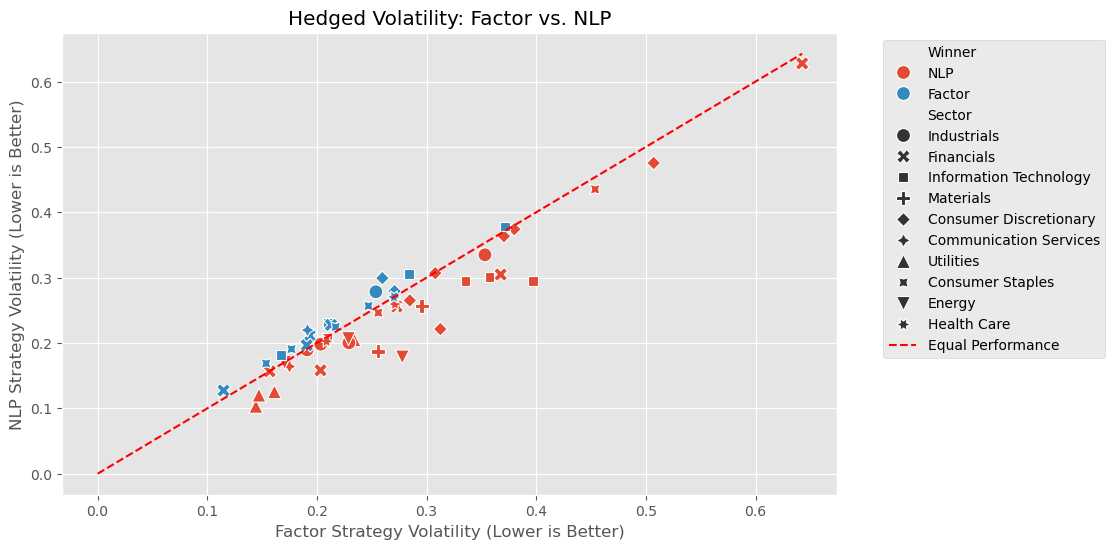

In [13]:
# Win Rate
win_counts = res_df['Winner'].value_counts()
print("Win Counts:\n", win_counts)

# Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(data=res_df, x='Factor_Vol', y='NLP_Vol', hue='Winner', style='Sector', s=100)

# Add 1:1 line (Below line = NLP better, Above line = Factor better)
max_vol = max(res_df['Factor_Vol'].max(), res_df['NLP_Vol'].max())
plt.plot([0, max_vol], [0, max_vol], 'r--', label='Equal Performance')

plt.title("Hedged Volatility: Factor vs. NLP")
plt.xlabel("Factor Strategy Volatility (Lower is Better)")
plt.ylabel("NLP Strategy Volatility (Lower is Better)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## 4. Deep Dive
Let's look at the specific cases where NLP won by a large margin. These often represent companies where the "Sector" label is misleading, but the Wikipedia text captured the true business risks.

In [14]:
# Show top 5 NLP wins
print("Top 5 NLP Wins (Biggest Risk Reduction vs Factor):")
display(res_df.sort_values('Risk_Reduction_bps', ascending=False).head(5))

# Show top 5 Factor wins
print("\nTop 5 Factor Wins:")
display(res_df.sort_values('Risk_Reduction_bps', ascending=True).head(5))

Top 5 NLP Wins (Biggest Risk Reduction vs Factor):


,Ticker,Factor_Vol,NLP_Vol,Sector,Winner,Risk_Reduction_bps
14,WDC,0.397190,0.295453,Information Technology,NLP,1017.367933
46,OVV,0.277858,0.178621,Energy,NLP,992.364970
7,TOL,0.312546,0.221258,Consumer Discretionary,NLP,912.880479
10,AEM,0.255619,0.187211,Materials,NLP,684.078221
21,FG,0.367580,0.304797,Financials,NLP,627.824251



Top 5 Factor Wins:


,Ticker,Factor_Vol,NLP_Vol,Sector,Winner,Risk_Reduction_bps
33,RACE,0.259677,0.299271,Consumer Discretionary,Factor,-395.937465
30,BCE,0.191442,0.219720,Communication Services,Factor,-282.776909
49,LDOS,0.253764,0.278310,Industrials,Factor,-245.457635
22,GEN,0.283957,0.306046,Information Technology,Factor,-220.896209
3,AAPL,0.210146,0.230160,Information Technology,Factor,-200.137025
